# Enunciado atividade

Implemente uma Rede Neural rasa para classificação de uma base multiclasse.

Esta rede deve:

- Aceitar rótulos que podem ser números ou textos: **;
- Predizer os rótulos originais da base de dados **;
- Passar por parâmetro no construtor:
  - Função de custo e cálculo do gradiente - **OK** - *parâmetro "custo": pode ser utilizado "custo perceptron", "adaline" e "hinge loss"* ;
  - Taxa de aprendizado - **OK** - *parâmetro "alpha"*;
  - Número máximo de iterações - **OK** - *parâmetro "maxiteracoes"*;
  - Threshold - **OK** - *parâmetro "threshold" (True/False - com sem função de ativação*
- Funcionar para bases binárias - **OK**.

Teste pelo menos duas funções de custo diferentes em uma base multiclasse e uma base binária. - **OK** - *Custo perceptron e Adaline*

Plote gráficos com os hiperplanos separadores encontrados pelos algoritmos de treinamento. Se a base escolhida tiver mais do que 2 características, escolha as que você julgar que fornecem a melhor visualização.

In [145]:
#LISTA DE LABELS PARA SER ATRIBUIDO ALEATORIAMENTE NO EXERCICIO
import requests
host_list_palavras = "https://www.mit.edu/~ecprice/wordlist.10000"
response = requests.get(host_list_palavras)

db_labels = response.content.splitlines()
db_labels = list(filter(lambda x: len(x) >= 5, db_labels))
db_labels = list(map(lambda x: x.decode("utf-8"), db_labels))
db_labels = list(map(lambda x: x.upper(), db_labels))

#random.sample(db_labels, 4)

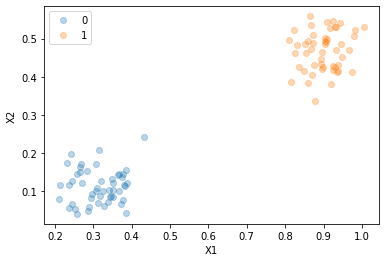

In [146]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize

def geradataset(tamanho=20, centros=2):
    X, y = make_blobs(n_samples=tamanho, centers=centros, center_box=(0, 1.0), cluster_std=0.05)
    labels = random.sample(db_labels, len(set(y)))
    labels_dict = {}
    for l in range(len(labels)):
      labels_dict[l]=labels[l]

    ylabeled = list(map(lambda x: labels_dict[x], y))

    return X, y, ylabeled

def plotadataset(X, y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3, label=list(set(y))[k])
    plt.legend()

def plotahiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)

X, y, ylabeled = geradataset(100,2)
plotadataset(X, y)
plt.show()
ybin = label_binarize(y, classes=list(set(y)))*2-1
#ybin

# Funções de custo

In [147]:
class CustoPerceptron():
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum(CustoPerceptron.erro(y, ypred)**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.erro(y, ypred))

In [148]:
class CustoAdaline():
  def __init__(self):
    self.preactivated = True

  @staticmethod
  def erro(y, ypred):
    return y - ypred

  @staticmethod
  def custo(y, ypred):
    return np.sum((1 - CustoAdaline.erro(y, ypred))**2)

  @staticmethod
  def gradiente(y, ypred, X):
    return np.matmul(X.T, CustoAdaline.erro(y, ypred))

# Perceptron

0.5
[ 0.22434573 -0.19718955] -0.017596556886921813


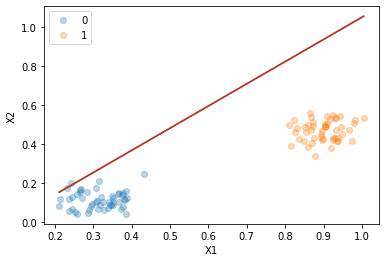

In [149]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Perceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, custo=CustoPerceptron(), alpha=0.001, maxiteracoes=200, threshold=True):
        self.w = None
        self.activation = lambda a: (a>=0)*2-1
        self.alpha = alpha
        self.maxiter = maxiteracoes
        self.custo = custo
        self.threshold = threshold
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    def fit(self, X, y):
        Xb = Perceptron.includebias(X)
        self.labels = list(set(y))
        if len(self.labels) > 2:
            y = label_binarize(y, classes=self.labels)*2-1
            #y.shape[1] = QUANTIDADE DE NEURONIOS DE SAÍDA
            self.w = np.random.uniform(-1, 1, size=(Xb.shape[1], y.shape[1]))
        else:
            self.w = np.random.uniform(-1, 1, size=Xb.shape[1])
        for _ in range(self.maxiter):
            a = self.preactivate(X)
            ypred = self.activation(a) if self.threshold else a
            custo = self.custo.custo(y, ypred)
            if custo == 0:
                break
            self.w = self.w + self.alpha*self.custo.gradiente(y, ypred, Xb)
    
    def preactivate(self, X):
        Xb = Perceptron.includebias(X)
        return np.matmul(Xb, self.w)

    def predict(self, X):
        a = self.preactivate(X)
        if len(self.w.shape)  > 1:
            idx = np.argmax(a, axis=1)
            ypred = np.array([self.labels[i] for i in idx])
        else:
            ypred = self.activation(a)
        return ypred


perceptron = Perceptron()
perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))
print(perceptron.w[1:], perceptron.w[0])

plotadataset(X, y)
classes = set(y)
for i in range(len(classes)):
    if len(classes) == 2:
      plotahiperplano(perceptron.w[1:], perceptron.w[0], min(X[:,0]), max(X[:,0]))
    else:
      plotahiperplano(perceptron.w[1:,i], perceptron.w[0,i], min(X[:,0]), max(X[:,0]))

# Testes

## Bases

In [150]:
bases = {}
bases['binaria'] = (geradataset(100,2))
bases['multiclasse'] = (geradataset(100,4))

#O geradataset retorna:
#X, y, labels

### Binária

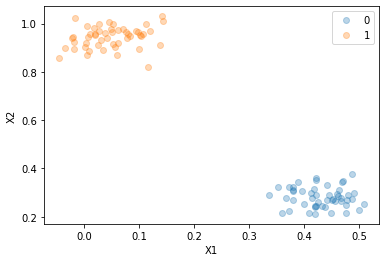

In [151]:
plotadataset(*bases['binaria'][:2])
plt.show()

### Multiclasse

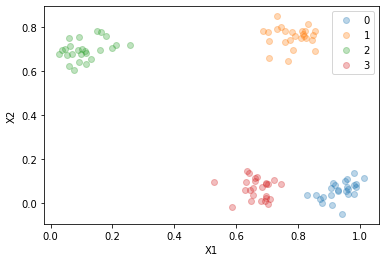

In [152]:
plotadataset(*bases['multiclasse'][:2])
plt.show()

## Adaline

##### Com base binária



0.5
[-1 -1  1 -1  1 -1  1 -1  1 -1 -1  1 -1  1  1  1 -1  1  1 -1  1  1  1 -1
  1 -1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1 -1
 -1  1  1 -1  1  1 -1  1  1  1  1  1 -1  1  1  1 -1  1  1 -1  1  1  1  1
 -1  1  1  1]
[0.55654758 0.56903596] -0.4014188234050894


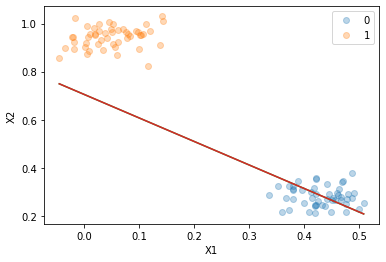

In [153]:
perceptron = Perceptron(custo=CustoAdaline())
X, y, ylabeled = bases['binaria']
#print(f"labels{set(ylabeled)}")

perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))
print(ypred)
print(perceptron.w[1:], perceptron.w[0])

plotadataset(X, y)
classes = set(y)
for i in range(len(classes)):
    if len(classes) == 2:
      plotahiperplano(perceptron.w[1:], perceptron.w[0], min(X[:,0]), max(X[:,0]))
    else:
      plotahiperplano(perceptron.w[1:,i], perceptron.w[0,i], min(X[:,0]), max(X[:,0]))

##### Com base multiclase

1.0
[[ 0.20635311  0.08858681 -0.12317453 -0.76708536]
 [-0.40660516  0.13059616  0.32273781 -0.99932718]] [-0.14555992 -0.14598973 -0.18416192  0.6631917 ]


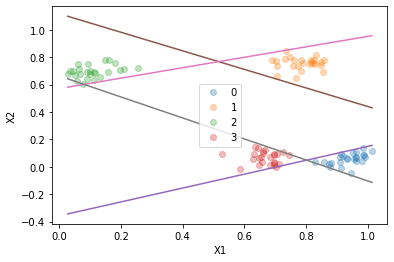

In [154]:
perceptron = Perceptron(custo=CustoAdaline())
X, y, ylabeled = bases['multiclasse']
#print(f"labels={set(ylabeled)}")

perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))

print(perceptron.w[1:], perceptron.w[0])

plotadataset(X, y)
classes = set(y)
for i in range(len(classes)):
    if len(classes) == 2:
      plotahiperplano(perceptron.w[1:], perceptron.w[0], min(X[:,0]), max(X[:,0]))
    else:
      plotahiperplano(perceptron.w[1:,i], perceptron.w[0,i], min(X[:,0]), max(X[:,0]))

## Custo Perceptron

##### Com base binária

0.5
[0.02242385 0.10958341] -0.006419105394814398


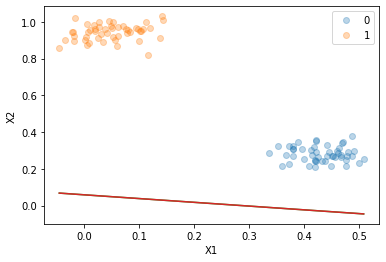

In [155]:
perceptron = Perceptron(custo=CustoPerceptron())
X, y, ylabeled = bases['binaria']
#print(f"labels={set(ylabeled)}")

perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))
print(perceptron.w[1:], perceptron.w[0])

plotadataset(X, y)
classes = set(y)
for i in range(len(classes)):
    if len(classes) == 2:
      plotahiperplano(perceptron.w[1:], perceptron.w[0], min(X[:,0]), max(X[:,0]))
    else:
      plotahiperplano(perceptron.w[1:,i], perceptron.w[0,i], min(X[:,0]), max(X[:,0]))

##### Com base multiclasse

1.0
[[ 0.32599189  0.62291473 -0.12314295 -0.23870644]
 [-0.03548352  0.64608277  0.21027401 -0.31772238]] [-0.26385659 -0.70908218 -0.09661167  0.20925368]


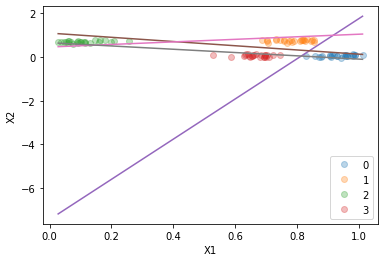

In [158]:
perceptron = Perceptron(custo=CustoPerceptron())
X, y, labels = bases['multiclasse']
#print(f"labels={labels}")

perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))
print(perceptron.w[1:], perceptron.w[0])

plotadataset(X, y)
classes = set(y)
for i in range(len(classes)):
    if len(classes) == 2:
      plotahiperplano(perceptron.w[1:], perceptron.w[0], min(X[:,0]), max(X[:,0]))
    else:
      plotahiperplano(perceptron.w[1:,i], perceptron.w[0,i], min(X[:,0]), max(X[:,0]))